<a href="https://colab.research.google.com/github/Arazahari/Massive-data/blob/main/algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installing Java and Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [5]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import os
import zipfile
from pathlib import Path

In [36]:
import os
import zipfile
from pathlib import Path

# Set my Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = "arazasgharieh"
os.environ['KAGGLE_KEY'] = "18630aca8449a80ac4369001a6d7cd40"


dataset_id = "mohamedbakhet/amazon-books-reviews"
data_path = Path("data/")

# Creating data folder and download the dataset
if not data_path.is_dir():
    data_path.mkdir(parents=True, exist_ok=True)
    os.chdir(data_path)


    !kaggle datasets download -d {dataset_id}

    os.chdir("/content/")

    # Find and unzip the file
    zip_file = next(data_path.glob("*.zip"))
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        print("Unzipping dataset...")
        zip_ref.extractall(data_path)
    zip_file.unlink()


In [37]:
os.listdir("data")

['Books_rating.csv', 'amazon-books-reviews.zip', 'books_data.csv']

In [38]:
books_rating = spark.read.csv('data/Books_rating.csv', header=True, inferSchema=True)
books_rating = books_rating.dropna(subset=["review/text"])

In [39]:
books_rating.count()

497383

In [40]:
books_rating.printSchema()

root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: string (nullable = true)
 |-- review/time: string (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)



In [41]:
books_rating.select("review/text").show(2, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [42]:
review_column = books_rating.select("review/text")

In [43]:
review_column.show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [44]:
# Sample 10% of the reviews
sample = review_column.sample(False, 0.1, seed=42)

In [45]:
from pyspark.sql.functions import col, lower, regexp_replace, split, array_distinct
from pyspark.ml.feature import StopWordsRemover

# Step 1: Tokenizing reviews into words
tokenized_sample = sample.select(
    split(
        regexp_replace(
            lower(col("review/text")),
            r"[^\w\s]", ""  # remove punctuation
        ),
        r"\s+"  # split by whitespace
    ).alias("raw_items")
)

# Step 2: Removing stopwords
remover = StopWordsRemover(inputCol="raw_items", outputCol="filtered_items")
tokenized_sample = remover.transform(tokenized_sample)

# Step 3: Removing duplicate words
tokenized_sample = tokenized_sample.withColumn("items", array_distinct(col("filtered_items")))

# Step 4: Keeping only the final items column
tokenized_sample = tokenized_sample.select("items")

# result
tokenized_sample.show(5, truncate=False)



+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|items                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [46]:
from pyspark.ml.fpm import FPGrowth

# Setting minimum support and confidence
fp_growth = FPGrowth(itemsCol="items", minSupport=0.05, minConfidence=0.1)

# Fitting the model
model = fp_growth.fit(tokenized_sample)


In [47]:
model.freqItemsets.orderBy("freq", ascending=False).limit(10).show(truncate=False)

+------------+-----+
|items       |freq |
+------------+-----+
|[book]      |34740|
|[read]      |20616|
|[read, book]|16347|
|[one]       |15364|
|[one, book] |11464|
|[like]      |10831|
|[story]     |10149|
|[books]     |9578 |
|[great]     |9549 |
|[good]      |9213 |
+------------+-----+



In [51]:
from pyspark.sql.functions import size

# Showing only itemsets with more than 1 word
model.freqItemsets.filter(size("items") == 1).show(10, truncate=False)

+------------+----+
|items       |freq|
+------------+----+
|[part]      |2642|
|[new]       |4682|
|[though]    |3203|
|[want]      |3872|
|[reading]   |8928|
|[understand]|2820|
|[put]       |3514|
|[people]    |6107|
|[cant]      |2489|
|[things]    |3304|
+------------+----+
only showing top 10 rows



In [52]:
model.associationRules.orderBy("confidence", ascending=False).limit(10).show(truncate=False)

+--------------+----------+------------------+------------------+-------------------+
|antecedent    |consequent|confidence        |lift              |support            |
+--------------+----------+------------------+------------------+-------------------+
|[think, read] |[book]    |0.8883349950149552|1.2669897044617444|0.0539476870913054 |
|[people, read]|[book]    |0.8778601353528843|1.2520499132545972|0.05497699200775006|
|[really, read]|[book]    |0.8746586564718732|1.2474837970888997|0.06464438524259304|
|[get, read]   |[book]    |0.8685887708649469|1.2388266096377774|0.05776217001695326|
|[also, read]  |[book]    |0.8684369342184671|1.2386100522929364|0.05808508920642609|
|[good, like]  |[book]    |0.8591646530894028|1.2253854413147303|0.0502341164123678 |
|[like, read]  |[book]    |0.8579689194073004|1.2236800235691687|0.09582626947606361|
|[first, read] |[book]    |0.8578970523537176|1.2235775230288428|0.07871155243400339|
|[even, read]  |[book]    |0.8566265060240964|1.221765

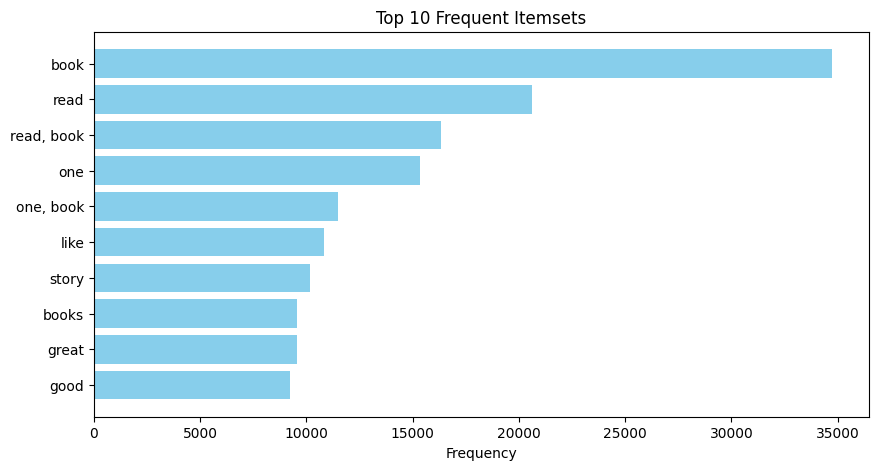

In [53]:
# Getting frequent itemsets from model
freq_itemsets = model.freqItemsets

# Converting to Pandas (limit to top 10 for performance)
top_freq = freq_itemsets.orderBy("freq", ascending=False).limit(10).toPandas()

# Joining items into string labels for plotting
top_freq["items"] = top_freq["items"].apply(lambda x: ", ".join(x))

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.barh(top_freq["items"], top_freq["freq"], color="skyblue")
plt.xlabel("Frequency")
plt.title("Top 10 Frequent Itemsets")
plt.gca().invert_yaxis()
plt.show()

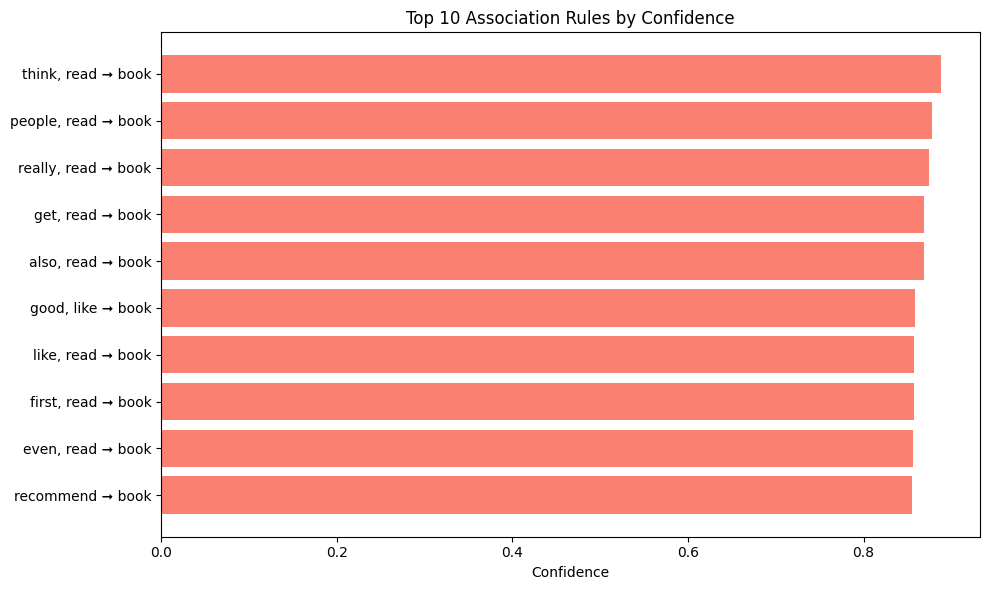

In [55]:
# Getting top 10 association rules by confidence
top_rules = model.associationRules.orderBy("confidence", ascending=False).limit(10).toPandas()

# Formatting the antecedent and consequent as strings
top_rules["rule"] = top_rules["antecedent"].apply(lambda x: ", ".join(x)) + " ➞ " + top_rules["consequent"].apply(lambda x: ", ".join(x))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_rules["rule"], top_rules["confidence"], color="salmon")
plt.xlabel("Confidence")
plt.title("Top 10 Association Rules by Confidence")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
